In [33]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import json
import matplotlib.pyplot as plt
import numpy as np

import recova.learning_dataset
from recova.learning.learning import model_from_file
from recova.util import kullback_leibler, wishart_kl_divergence

np.set_printoptions(precision=3, linewidth=100)

In [35]:
DATASET_FILE = '/home/dlandry/dataset/learning_sets/2018-08-14-inside.json'
LEARNING_RUN_FILE = '/home/dlandry/dataset/learning_runs/2018-08-14-haupt.json'
MODEL_FILE = '/home/dlandry/dataset/learning_runs/2018-08-14-haupt.model'

In [36]:
with open(DATASET_FILE) as f:
    dataset = json.load(f)
    
with open(LEARNING_RUN_FILE) as f:
    learning_run = json.load(f)
    
model = model_from_file(MODEL_FILE, 'cello')

In [37]:
xs = np.array(dataset['data']['xs'])
ys = np.array(dataset['data']['ys'])


train_set = learning_run['train_set']
validation_set = learning_run['validation_set']

In [38]:
validation_xs = xs[validation_set]
validation_ys = ys[validation_set]

In [39]:
predictions = model.predict(validation_xs)

6
6


In [52]:
reference_norms = np.zeros(len(predictions))
prediction_norms = np.zeros(len(predictions))
norm_loss = np.zeros(len(predictions))
wishart_kl = np.zeros(len(predictions))
gaussian_kl = np.zeros(len(predictions))
percent_loss = np.zeros(len(predictions))

for i in range(len(predictions)):
    reference_norms[i] = np.linalg.norm(ys[validation_set[i]])
    prediction_norms[i] = np.linalg.norm(predictions[i])
    wishart_kl[i] = wishart_kl_divergence(ys[validation_set[i]], 6, predictions[i], 6)
    norm_loss[i] = np.linalg.norm(ys[validation_set[i]] - predictions[i])
    percent_loss = abs(norm_loss[i] / np.linalg.norm(ys[validation_set[i]]))
    gaussian_kl[i] = kullback_leibler(ys[validation_set[i]], predictions[i])
    
    print('{}: {}'.format(i, gaussian_kl[i]))

2.9835775039840846e-58
8.166160545841759e-46
0: 11.366687107792593
2.0230907666875195e-57
6.494568552228141e-46
1: 10.305457851947804
1.783204211051452e-57
1.8989299990130778e-45
2: 10.897786689432587
1.7728720169878847e-57
4.1289434408141854e-45
3: 11.284438411416344
1.9504228680927086e-57
6.53768609284555e-46
4: 10.32696716592623
4.670082613061397e-59
8.035605618239658e-46
5: 12.284760776148705
2.4196803510871393e-57
3.05986287614819e-45
6: 10.983066376783391
2.284001137874637e-56
2.725951653056418e-45
7: 9.86035117890393
2.3692021053992597e-56
4.119023379572637e-45
8: 10.04005699797939
2.7549567397358784e-56
2.02848427834503e-45
9: 9.624387963372554
2.755779092876436e-56
9.420967605939377e-46
10: 9.254318007309529
2.984417232567634e-56
3.5444698950225076e-45
11: 9.854942712013461
2.372277572915856e-56
3.574681720033315e-45
12: 9.970679212094536
2.4418781765814076e-53
1.1772111814342881e-45
13: 10.64789833011431
2.606637936142345e-56
5.056619009674818e-46
14: 8.982926177931944
2.5585

/home/dlandry/repos/registration-covariance-analysis/recova/util.py:279: RuntimeWarning: invalid value encountered in log
  ((base_degress_of_freedom - prediction_degrees_of_freedom) / 2.) * scipy.special.polygamma(1, base_degress_of_freedom / 2.)
/home/dlandry/repos/registration-covariance-analysis/recova/util.py:279: RuntimeWarning: divide by zero encountered in log
  ((base_degress_of_freedom - prediction_degrees_of_freedom) / 2.) * scipy.special.polygamma(1, base_degress_of_freedom / 2.)


195: 8.190955470827097
1.9716453258962016e-55
3.4746264374782656e-46
196: 7.836859577681074
2.2199413733787283e-55
2.1321343893976023e-46
197: 7.546974937038796
9.379720548316598e-56
3.5798329809847926e-46
198: 8.219745525024415
1.9803310208889597e-55
7.514511067762163e-46
199: 8.19981492603404
2.3848559721960697e-55
1.2515902326196931e-46
200: 7.263479759625995
1.0138392060648067e-55
5.516244036988652e-47
201: 7.301897485057125
1.780775994254307e-55
2.0446994257244598e-45
202: 8.732316683279478
3.0207350043230836e-54
4.0949743875137705e-46
203: 8.00332885788589
2.906880281547923e-54
6.2066544953706725e-46
204: 8.122426414247096
6.750420054370405e-54
5.034411732745655e-46
205: 7.665335289326548
8.705675299984479e-54
8.79979232846716e-46
206: 7.697867363785379
8.297490456299448e-54
2.385534594698928e-46
207: 7.389031675346836
8.622519284996876e-54
2.6239996911259393e-45
208: 8.021280386205914
2.8524620298168824e-54
1.1520631504677083e-46
209: 7.775201146788307
1.7998724428917684e-55
4.6

2.2171376041522553e-71
1.221228276605258e-43
584: 28.995609399416242
3.329016768011375e-66
4.4822473258799025e-43
585: 23.678127814943036
6.965971320535973e-56
1.8308283486730046e-42
586: 12.490850500170332
2.369265158898826e-56
1.111445772773266e-43
587: 11.647179219044512
1.743473614957003e-56
1.0061308550514406e-43
588: 11.747759494327195
2.348283055102401e-56
1.843088741998162e-43
589: 11.897451144646865
2.141571923264184e-56
1.6486172786535796e-43
590: 11.888683860507141
1.6810238467207155e-56
1.029597939277423e-42
591: 12.91400412258627
1.1352589391461618e-56
2.281960757198313e-43
592: 12.366490011490228
2.929906827245395e-56
3.8640314848931244e-42
593: 13.291081258538515
1.6884677366955228e-56
2.5786122659828617e-43
594: 12.228868125532413
1.9142288182192343e-57
4.830881162321117e-43
595: 13.603324456252459
1.658218734022541e-57
7.324741889223692e-43
596: 13.88183793268307
1.331130525599151e-57
6.892943044024142e-43
597: 13.961087727978324
1.7927344553015425e-57
3.54043192731896

In [53]:
gaussian_kl[123]

kullback_leibler(ys[validation_set[123]], predictions[i])

print(ys[validation_set[123]])
print(np.linalg.det(ys[validation_set[123]] + np.identity(6) * 1e-15))

5.249116762785251e-68
2.5289702864822343e-45
[[ 5.456e-09 -1.509e-09  2.643e-10  1.681e-11 -2.768e-11  4.989e-11]
 [-1.509e-09  9.016e-10  1.157e-10 -6.626e-12  1.091e-11 -1.966e-11]
 [ 2.643e-10  1.157e-10  1.875e-09 -4.947e-12  8.144e-12 -1.468e-11]
 [ 1.681e-11 -6.626e-12 -4.947e-12  9.613e-13 -1.583e-12  2.853e-12]
 [-2.768e-11  1.091e-11  8.144e-12 -1.583e-12  2.606e-12 -4.697e-12]
 [ 4.989e-11 -1.966e-11 -1.468e-11  2.853e-12 -4.697e-12  8.465e-12]]
5.249116762785251e-68


In [54]:
wishart_kl.mean()
np.median(wishart_kl)

/home/dlandry/.envs/recov/lib/python3.5/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


nan

In [55]:
print('Avg. Norm loss: {:.2E}'.format(norm_loss.mean()))
print('Avg. Percent loss: {:.2E}'.format(percent_loss.mean()))
print('Avg. Wishart KL loss: {:.2E}'.format(wishart_kl.mean()))
print('Avg. Gaussian KL loss: {:.1f}'.format(gaussian_kl.mean()))

Avg. Norm loss: 6.55E-07
Avg. Percent loss: 4.54E+01
Avg. Wishart KL loss: NAN
Avg. Gaussian KL loss: 12.1


<IPython.core.display.Javascript object>


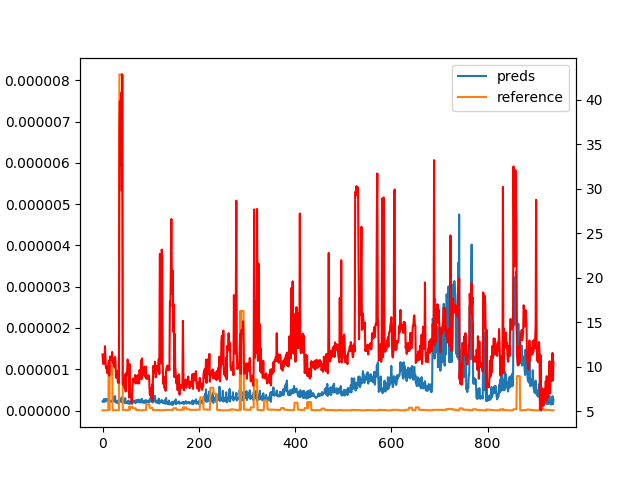

In [56]:
plt.plot(list(range(len(predictions))), prediction_norms, label='preds')
plt.plot(list(range(len(predictions))), reference_norms, label='reference')
plt.legend()
ax = plt.gca()
ax2 = ax.twinx()

ax2.plot(list(range(len(predictions))), gaussian_kl, color='red')


In [155]:
p = predictions[750]
ref = ys[validation_set[750]]

In [156]:
wishart_kl_divergence(ref, 6, p, 6)

51.031103968177916

In [157]:
p

array([[ 4.013e-07,  7.248e-08,  1.874e-08,  2.451e-08, -6.662e-08, -5.575e-11],
       [ 7.248e-08,  9.845e-07,  9.263e-08,  1.267e-07,  2.049e-08, -4.435e-09],
       [ 1.874e-08,  9.263e-08,  1.146e-07, -1.281e-08,  2.051e-08, -9.757e-09],
       [ 2.451e-08,  1.267e-07, -1.281e-08,  8.619e-08, -2.056e-08,  2.142e-08],
       [-6.662e-08,  2.049e-08,  2.051e-08, -2.056e-08,  3.900e-08, -8.761e-11],
       [-5.575e-11, -4.435e-09, -9.757e-09,  2.142e-08, -8.761e-11,  1.248e-07]], dtype=float32)

In [158]:
ref

array([[ 6.039e-08,  4.200e-09, -5.947e-09, -1.462e-10, -4.587e-09,  4.113e-10],
       [ 4.200e-09,  1.239e-08,  2.217e-09,  1.096e-09, -2.594e-10, -1.896e-10],
       [-5.947e-09,  2.217e-09,  1.030e-08,  3.607e-10,  1.207e-09,  6.554e-11],
       [-1.462e-10,  1.096e-09,  3.607e-10,  5.563e-10,  3.015e-12,  3.803e-12],
       [-4.587e-09, -2.594e-10,  1.207e-09,  3.015e-12,  1.596e-09, -8.056e-11],
       [ 4.113e-10, -1.896e-10,  6.554e-11,  3.803e-12, -8.056e-11,  2.506e-10]])

In [159]:
p - ref

array([[ 3.409e-07,  6.828e-08,  2.469e-08,  2.465e-08, -6.203e-08, -4.670e-10],
       [ 6.828e-08,  9.721e-07,  9.042e-08,  1.256e-07,  2.074e-08, -4.246e-09],
       [ 2.469e-08,  9.042e-08,  1.043e-07, -1.317e-08,  1.931e-08, -9.823e-09],
       [ 2.465e-08,  1.256e-07, -1.317e-08,  8.564e-08, -2.057e-08,  2.141e-08],
       [-6.203e-08,  2.074e-08,  1.931e-08, -2.057e-08,  3.740e-08, -7.050e-12],
       [-4.670e-10, -4.246e-09, -9.823e-09,  2.141e-08, -7.050e-12,  1.246e-07]])

In [160]:
(p - ref) / ref

array([[ 5.646e+00,  1.626e+01, -4.152e+00, -1.687e+02,  1.352e+01, -1.136e+00],
       [ 1.626e+01,  7.847e+01,  4.078e+01,  1.146e+02, -7.998e+01,  2.239e+01],
       [-4.152e+00,  4.078e+01,  1.012e+01, -3.652e+01,  1.600e+01, -1.499e+02],
       [-1.687e+02,  1.146e+02, -3.652e+01,  1.539e+02, -6.821e+03,  5.631e+03],
       [ 1.352e+01, -7.998e+01,  1.600e+01, -6.821e+03,  2.344e+01,  8.751e-02],
       [-1.136e+00,  2.239e+01, -1.499e+02,  5.631e+03,  8.751e-02,  4.970e+02]])